### 3. Experimental Comparison: ISTA vs FISTA

#### (a) Fixed Step Size

From the results:

- **ISTA (fixed)** took **1.6203 s** and **23,275 iterations**
- **FISTA (fixed)** took only **0.1200 s** and **1,000 iterations**

We observe that **FISTA converges significantly faster** than ISTA when using a fixed step size, both in terms of iteration count and wall-clock time.

#### (b) Backtracking Line Search

- **ISTA (backtracking)**: **3.2280 s**, **5,851 iterations**
- **FISTA (backtracking)**: **0.1718 s**, **1,170 iterations**

Even with backtracking, **FISTA outperforms ISTA**. While backtracking reduces the number of iterations required by ISTA (compared to fixed step), it increases the per-iteration cost. FISTA still achieves the target accuracy in fewer iterations and in less time.

#### Conclusion

Across both settings, **FISTA is clearly faster** and more efficient than ISTA. This advantage holds whether we use a fixed step size or backtracking line search. FISTA’s theoretical acceleration translates into substantial practical gains. Backtracking is slower for both cases, probably because we are checking for more stuff. 

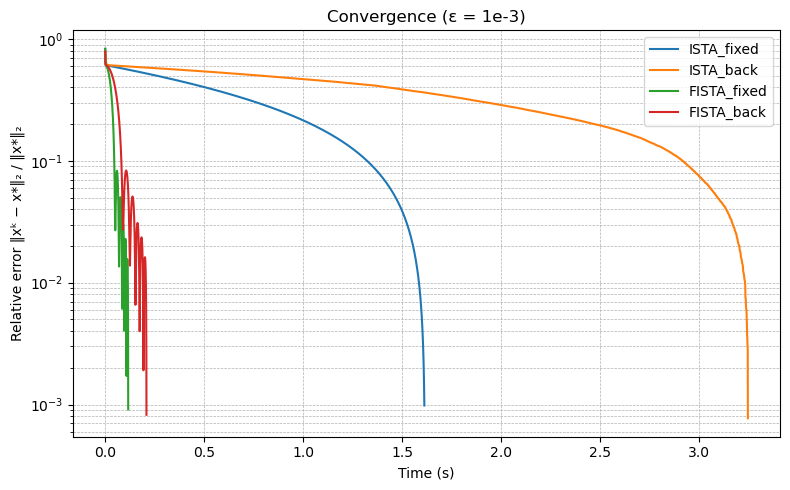

ISTA_fixed    →  Time: 1.6125 s,  Iterations: 23275
ISTA_back     →  Time: 3.2472 s,  Iterations: 5851
FISTA_fixed   →  Time: 0.1161 s,  Iterations: 1000
FISTA_back    →  Time: 0.2084 s,  Iterations: 1170


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# ─── 1) Data generation for Problem 1 ─────────────────────────────────────────
m, n, s = 300, 500, 2
np.random.seed(0)

# A ∈ R^{m×n}, sparse x_* with s=2 nonzeros of size ~100
A = np.random.randn(m, n)
x_star = np.zeros(n)
p = np.random.permutation(n)
x_star[p[:s]] = 100 * np.random.randn(s)
b = A.dot(x_star)

τ = 1.0  # LASSO weight

# smooth part g(x) = ||Ax - b||_2^2
def g(x):
    return np.linalg.norm(A.dot(x) - b) ** 2

# full LASSO objective f(x) = g(x) + τ ||x||_1
def objective(x):
    return g(x) + τ * np.linalg.norm(x, 1)

# Soft‐thresholding operator: prox_{τ}(·)
def soft_threshold(z, lam):
    return np.sign(z) * np.maximum(np.abs(z) - lam, 0.0)


# ─── 2) ISTA with fixed step‐size ─────────────────────────────────────────────
def ista_fixed(A, b, τ, x0, eps, max_iter=10**6):
    x = x0.copy()
    f_star = objective(x_star)
    L = 2 * np.linalg.norm(A, 2)**2      # Lipschitz of ∇g(x)
    t = 1.0 / L                           # fixed step = 1/L
    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        # 1) gradient of g at x
        grad = 2 * A.T.dot(A.dot(x) - b)
        # 2) ISTA update: x ← soft_threshold(x - t⋅grad, t⋅τ)
        x = soft_threshold(x - t * grad, t * τ)

        # 3) track relative error
        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 3) ISTA with backtracking line‐search ───────────────────────────────────
def ista_backtracking(A, b, τ, x0, eps, max_iter=10**6, t_init=1.0, beta=0.5):
    x = x0.copy()
    f_star = objective(x_star)
    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        grad = 2 * A.T.dot(A.dot(x) - b)
        t = t_init

        # Backtracking loop: find t so that
        # g(x_new) ≤ g(x) + ∇g(x)^T (x_new - x) + (1/(2t)) ||x_new - x||^2
        while True:
            # candidate x_new via prox step
            x_new = soft_threshold(x - t * grad, t * τ)
            lhs = g(x_new)
            diff = x_new - x
            rhs = (
                g(x)
                + grad.dot(diff)
                + 0.5 * (1.0 / t) * np.linalg.norm(diff)**2
            )
            if lhs <= rhs:
                break
            t *= beta

        x = x_new
        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 4) FISTA with fixed step‐size ───────────────────────────────────────────
def fista_fixed(A, b, τ, x0, eps, max_iter=10**6):
    x_old = x0.copy()    # x^{k-1}
    x = x0.copy()        # x^k
    f_star = objective(x_star)
    L = 2 * np.linalg.norm(A, 2)**2
    t = 1.0 / L

    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        if k == 1:
            y = x
        else:
            # momentum step: y = x^k + ((k-2)/(k+1)) (x^k - x^{k-1})
            y = x + ((k - 2) / (k + 1)) * (x - x_old)

        grad_y = 2 * A.T.dot(A.dot(y) - b)
        x_new = soft_threshold(y - t * grad_y, t * τ)

        x_old = x
        x = x_new

        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 5) FISTA with backtracking line‐search ──────────────────────────────────
def fista_backtracking(A, b, τ, x0, eps, max_iter=10**6, t_init=1.0, beta=0.5):
    x_old = x0.copy()
    x = x0.copy()
    f_star = objective(x_star)
    t = t_init

    errors, f_diffs = [], []
    t_start = time.time()

    for k in range(1, max_iter + 1):
        if k == 1:
            y = x
        else:
            # momentum: y = x^k + ((k-2)/(k+1))(x^k - x^{k-1})
            y = x + ((k - 2) / (k + 1)) * (x - x_old)

        grad_y = 2 * A.T.dot(A.dot(y) - b)
        t_k = t

        # Backtracking: find t_k so that
        # g(x_new) ≤ g(y) + ∇g(y)^T (x_new - y) + (1/(2 t_k)) ||x_new - y||^2
        while True:
            x_temp = soft_threshold(y - t_k * grad_y, t_k * τ)
            lhs = g(x_temp)
            diff = x_temp - y
            rhs = (
                g(y)
                + grad_y.dot(diff)
                + 0.5 * (1.0 / t_k) * np.linalg.norm(diff) ** 2
            )
            if lhs <= rhs:
                break
            t_k *= beta

        x_old = x
        x = x_temp
        t = t_k  # carry forward this t_k for the next iteration

        rel_err = np.linalg.norm(x - x_star) / np.linalg.norm(x_star)
        errors.append(rel_err)
        f_diffs.append(objective(x) - f_star)
        if rel_err < eps:
            break

    total_time = time.time() - t_start
    return x, errors, f_diffs, total_time


# ─── 6) Run all four methods (ε = 1e-3) ────────────────────────────────────────
eps = 1e-3
x0 = np.zeros(n)

x_if, err_if, f_if, t_if = ista_fixed(A, b, τ, x0, eps)
x_ib, err_ib, f_ib, t_ib = ista_backtracking(A, b, τ, x0, eps)

x_ff, err_ff, f_ff, t_ff = fista_fixed(A, b, τ, x0, eps)
x_fb, err_fb, f_fb, t_fb = fista_backtracking(A, b, τ, x0, eps)

results = {
    'ISTA_fixed':   {'time': t_if, 'errors': err_if},
    'ISTA_back':    {'time': t_ib, 'errors': err_ib},
    'FISTA_fixed':  {'time': t_ff, 'errors': err_ff},
    'FISTA_back':   {'time': t_fb, 'errors': err_fb},
}

# ─── 7) Plot convergence curves ───────────────────────────────────────────────
plt.figure(figsize=(8, 5))
for label, data in results.items():
    iters = len(data['errors'])
    # approximate cumulative time (uniform distribution over iterations)
    if iters > 0:
        t_cumsum = np.cumsum([data['time'] / iters] * iters)
        plt.semilogy(t_cumsum, data['errors'], label=label)

plt.xlabel('Time (s)')
plt.ylabel('Relative error ‖xᵏ − x*‖₂ / ‖x*‖₂')
plt.title('Convergence (ε = 1e-3)')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()

# ─── 8) Print a brief summary ─────────────────────────────────────────────────
for label, data in results.items():
    print(f"{label:12s}  →  Time: {data['time']:.4f} s,  Iterations: {len(data['errors'])}")